<a href="https://colab.research.google.com/github/JanaStefan/IANNwTF_g22/blob/main/cnn_jana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
from keras import layers, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.datasets import cifar10

1. Preparation and Inspection of the Data

In [2]:
def prep_cifar(train_data, test_data, batch_size, shuffle_buffer_size):
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img/128) - 1 #// normalized
        label = tf.one_hot(label, depth=10)
        return img, label
    train_data  = train_data.map(lambda img, label: preprocessing_func(img, label))
    train_data = train_data.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(2)
    test_data = test_data.map(lambda img, label: preprocessing_func(img, label))
    test_data = test_data.batch(1)
    return train_data, test_data


def get_familiar_with_data(dataset, name):
    for images, labels in dataset.take(1):
        print(f"{name} batch size:", images.shape[0])
        print("Each image size:", images.shape[1:])
        sample_labels = labels.numpy()
        print(f"Sample labels from {name} set:", sample_labels[:5] if sample_labels.ndim > 0 else sample_labels)

def visualize_data(dataset):
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        num_images = min(images.shape[0], 25)

        for i in range(num_images):
            plt.subplot(5, 5, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i], cmap=plt.cm.binary)
            plt.xlabel(class_names[labels[i].numpy()])

    plt.show()

In [3]:

train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteE5QG29/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteE5QG29/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


cifar batch size: 32
Each image size: (32, 3)
Sample labels from cifar set: 7


InvalidArgumentError: ignored

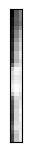

In [30]:
get_familiar_with_data(train_data, 'cifar')
visualize_data(train_data)

2. The CNN Model

In [4]:
class CNN():
    def __init__(self, input_size=(32, 32, 3), num_filters=[32, 64, 128], kernel_size=[(3,3), (3,3), (3,3)], strides=[(1,1), (1,1), (1,1)], conv_activation='relu', cnn_pool_type="max_pool",
                 padding="valid", use_bias=False, dense_activation='relu', dense_sizes=[256], num_classes=10, flatten_type="global_max", name="CNN_model"):

        self.input_size = input_size
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.conv_activation = conv_activation
        self.cnn_pool_type = cnn_pool_type
        self.padding = padding
        self.use_bias = use_bias
        self.dense_activation = dense_activation
        self.dense_sizes = dense_sizes
        self.num_classes = num_classes
        self.flatten_type = flatten_type
        self.name = name
        self.last_performance = {
            'train_loss_results': [],
            'train_accuracy_results': [],
            'test_loss': -1,
            'test_accuracy': -1,
        }

        self.model = None
        self.create_cnn()



    def create_cnn(self):
        inputs = layers.Input(shape=(self.input_size), dtype=tf.float32)
        x = inputs

        # Create CNN part with pooling layers
        for i, num_filter in enumerate(self.num_filters):
            x = layers.Conv2D(num_filter, self.kernel_size[i], self.strides[i], self.padding, activation=self.conv_activation, use_bias=self.use_bias)(x)
            x = layers.BatchNormalization()(x)
            if self.cnn_pool_type == "max_pool":
                x = layers.MaxPool2D()(x)
            else:
                x = layers.AveragePooling2D()(x)
            #x = layers.Dropout(0.2)(x)

        # Flatten the output of the CNN part for it to fit into the MLP part
        if self.flatten_type == "global_max":
            x = layers.GlobalMaxPool2D()(x)
        else:
            x = layers.GlobalAveragePooling2D()(x)

        # Create the MLP part
        for i, dense_size in enumerate(self.dense_sizes):
            x = layers.Dense(dense_size, activation=self.dense_activation)(x)

        # Create the output part
        y = layers.Dense(units=self.num_classes, activation='softmax')(x)

        self.model = keras.Model(inputs=inputs, outputs=y, name=self.name)
        self.model.summary()




    def train(self, train_data, test_data, batch_size=64, shuffle_buffer_size=1000, epochs=15, learning_rate=0.01, optimizer='adam'):
        train_data, test_data = prep_cifar(train_data, test_data, batch_size, shuffle_buffer_size)

        if optimizer == 'adam':
          optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
        else:
          optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        loss_f = tf.keras.losses.CategoricalCrossentropy()

        for epoch in range(epochs):
            epoch_loss_avg = tf.keras.metrics.Mean()
            epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
            for image, label in train_data:
                with tf.GradientTape() as tape:
                  pred = self.model(image)
                  loss = loss_f(label, pred)

                gradients = tape.gradient(loss, self.model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

                epoch_loss_avg.update_state(loss)
                epoch_accuracy.update_state(label, pred)

            self.last_performance['train_loss_results'].append(epoch_loss_avg.result())
            self.last_performance['train_accuracy_results'].append(epoch_accuracy.result())
            print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")


        self.last_performance['test_loss'], self.last_performance['test_accuracy'] = self.evaluate(test_data)
        print(f"Test Loss: {self.last_performance['test_loss']}, Test Accuracy: {self.last_performance['test_accuracy']}")
        return self.last_performance['train_loss_results'], self.last_performance['train_accuracy_results'], self.last_performance['test_loss'], self.last_performance['test_accuracy']




    def evaluate(self, test_data):
      loss_f = tf.keras.losses.CategoricalCrossentropy()
      loss_list = []
      correct_predictions = 0
      for image, label in test_data:
          pred = self.model(image)
          loss = loss_f(label, pred)
          loss_list.append(loss)
          if np.argmax(label, axis=-1) == np.argmax(pred, axis=-1):
              correct_predictions += 1
      return np.average(loss_list), correct_predictions/len(test_data)




    def visualize_last_performance(self):
        # Plot training loss and accuracy
        epochs_range = range(len(self.last_performance['train_loss_results']))
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.last_performance['train_loss_results'], label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.last_performance['train_accuracy_results'], label='Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()

        # Print and visualize test accuracy
        print(f"Test accuracy: {self.last_performance['test_accuracy']}")
        print(f"Test loss: {self.last_performance['test_loss']}")

        plt.show()




Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_24 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 64)        18432     
                                                                 
 batch_normalization_25 (Ba  (None, 13, 13, 64)        25

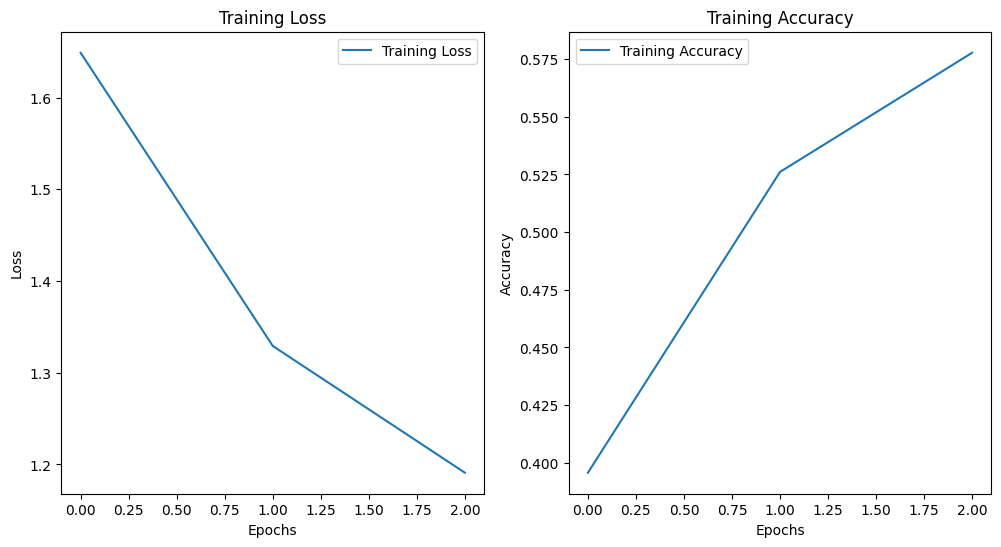

In [24]:
# Default Set of Hyperparameters for Testing Purposes

cnn_model = CNN()
performance_results = cnn_model.train(train_data, test_data, epochs=3)
cnn_model.visualize_last_performance()

3. Hyperparameter Tuning

Model: "Set_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_56 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 13, 13, 64)        18432     
                                                                 
 batch_normalization_57 (Ba  (None, 13, 13, 64)        256   

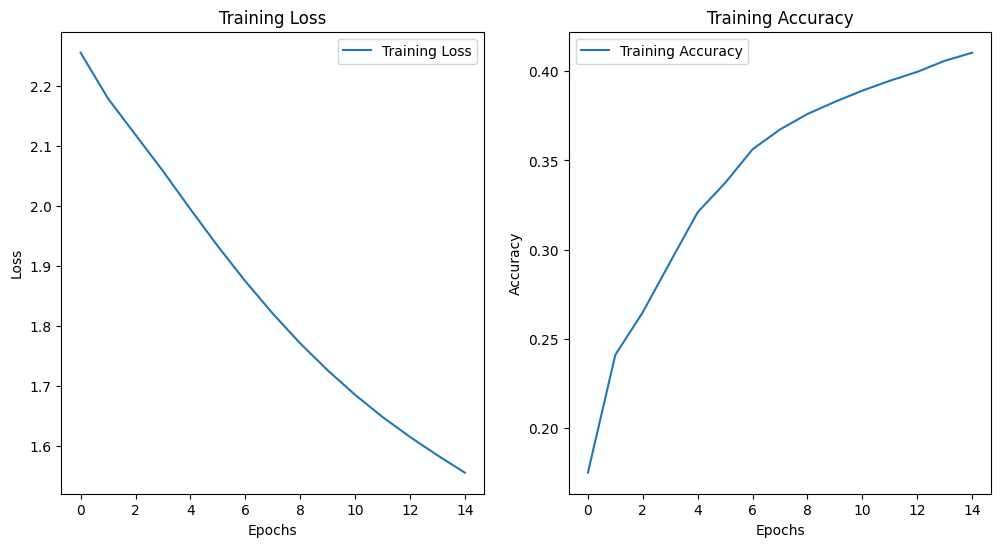

In [43]:
# Set 1:
set1_model = CNN(
    num_filters=[32, 64, 128],
    kernel_size=[(3,3), (3,3), (3,3)],
    strides=[(1,1), (1,1), (1,1)],
    conv_activation='elu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=False,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_1",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)
set1_model.train(train_data, test_data, batch_size=32, shuffle_buffer_size=500, epochs=15, learning_rate=0.0001, optimizer='rmsprop')
set1_model.visualize_last_performance()

Discussion of result:
Slow learning due to low learning rate -> would need more epochs of training for a better performance

Model: "Set_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_59 (Conv2D)          (None, 16, 16, 32)        384       
                                                                 
 batch_normalization_59 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (None, 6, 6, 64)          18432     
                                                                 
 batch_normalization_60 (Ba  (None, 6, 6, 64)          256   

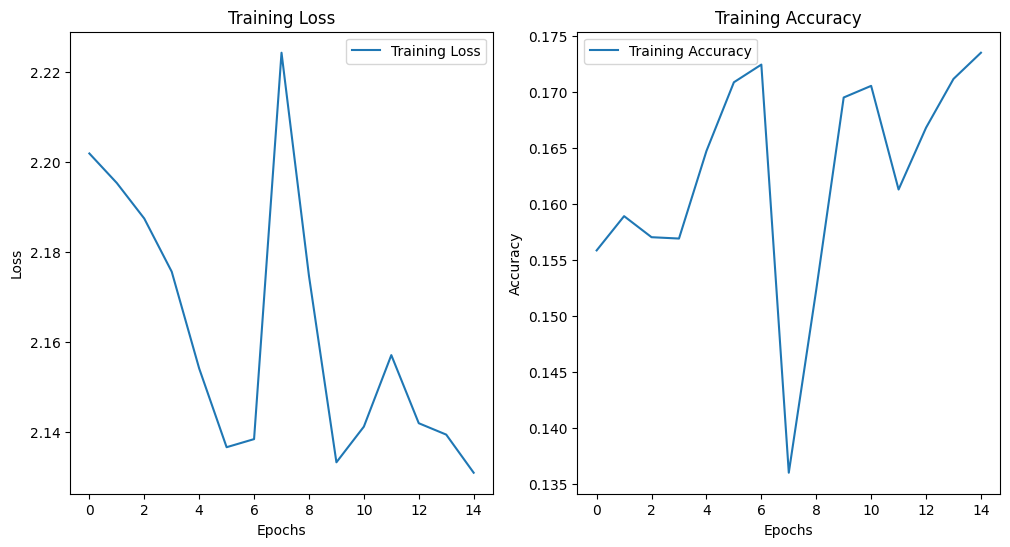

In [44]:
# Set 2:
set2_model = CNN(
    num_filters=[32, 64, 128],
    kernel_size=[(2,2), (3,3), (2,2)],
    strides=[(2,2), (1,1), (1,1)],
    conv_activation='elu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=False,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_2",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)
set2_model.train(train_data, test_data, batch_size=32, shuffle_buffer_size=1000, epochs=15, learning_rate=0.01, optimizer='rmsprop')
set2_model.visualize_last_performance()

Model: "Set_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 16, 16, 64)        832       
                                                                 
 batch_normalization_62 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_63 (Conv2D)          (None, 6, 6, 128)         73856     
                                                                 
 batch_normalization_63 (Ba  (None, 6, 6, 128)         512   

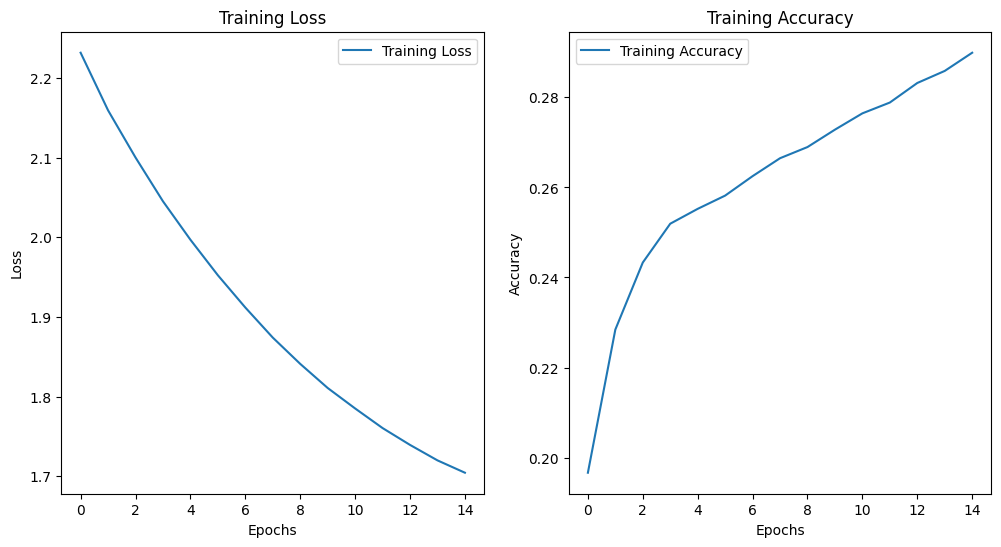

In [45]:
# Set 3:
set3_model = CNN(
    num_filters=[64, 128, 128],
    kernel_size=[(2,2), (3,3), (2,2)],
    strides=[(2,2), (1,1), (1,1)],
    conv_activation='relu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_3",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)
set3_model.train(train_data, test_data, batch_size=32, shuffle_buffer_size=1000, epochs=15, learning_rate=0.0001, optimizer='adam')
set3_model.visualize_last_performance()

Model: "Set_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        832       
                                                                 
 batch_normalization (Batch  (None, 16, 16, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 64)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 batch_normalization_1 (Bat  (None, 6, 6, 128)         512   

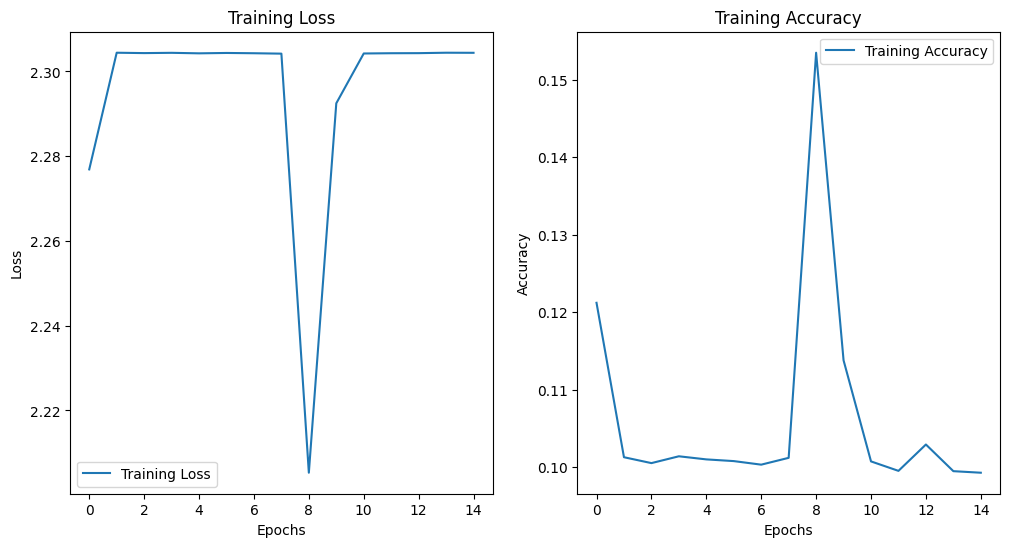

In [6]:
# Set 4:
set4_model = CNN(
    num_filters=[64, 128, 128],
    kernel_size=[(2,2), (3,3), (2,2)],
    strides=[(2,2), (1,1), (1,1)],
    conv_activation='relu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_4",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)
set4_model.train(train_data, test_data, batch_size=64, shuffle_buffer_size=500, epochs=15, learning_rate=0.01, optimizer='rmsprop')
set4_model.visualize_last_performance()

Model: "Set_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 15, 15, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 15, 15, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 batch_normalization_1 (Bat  (None, 3, 3, 64)          256   

Epoch 1: Loss: 2.0512163639068604, Accuracy: 0.22040000557899475
Epoch 2: Loss: 1.9746171236038208, Accuracy: 0.25992000102996826
Epoch 3: Loss: 1.998927116394043, Accuracy: 0.25352001190185547
Epoch 4: Loss: 2.024611473083496, Accuracy: 0.24785999953746796
Epoch 5: Loss: 2.036195755004883, Accuracy: 0.23462000489234924
Epoch 6: Loss: 2.032221555709839, Accuracy: 0.23637999594211578
Epoch 7: Loss: 2.0294365882873535, Accuracy: 0.24194000661373138
Epoch 8: Loss: 2.027324914932251, Accuracy: 0.2457199990749359
Epoch 9: Loss: 2.0405125617980957, Accuracy: 0.23771999776363373
Epoch 10: Loss: 2.0341074466705322, Accuracy: 0.2273000031709671
Epoch 11: Loss: 2.0427634716033936, Accuracy: 0.222680002450943
Epoch 12: Loss: 2.065814971923828, Accuracy: 0.20861999690532684
Epoch 13: Loss: 2.0773568153381348, Accuracy: 0.20080000162124634
Epoch 14: Loss: 2.0718135833740234, Accuracy: 0.21106000244617462
Epoch 15: Loss: 2.098418712615967, Accuracy: 0.19913999736309052
Test Loss: 2.078972816467285, 

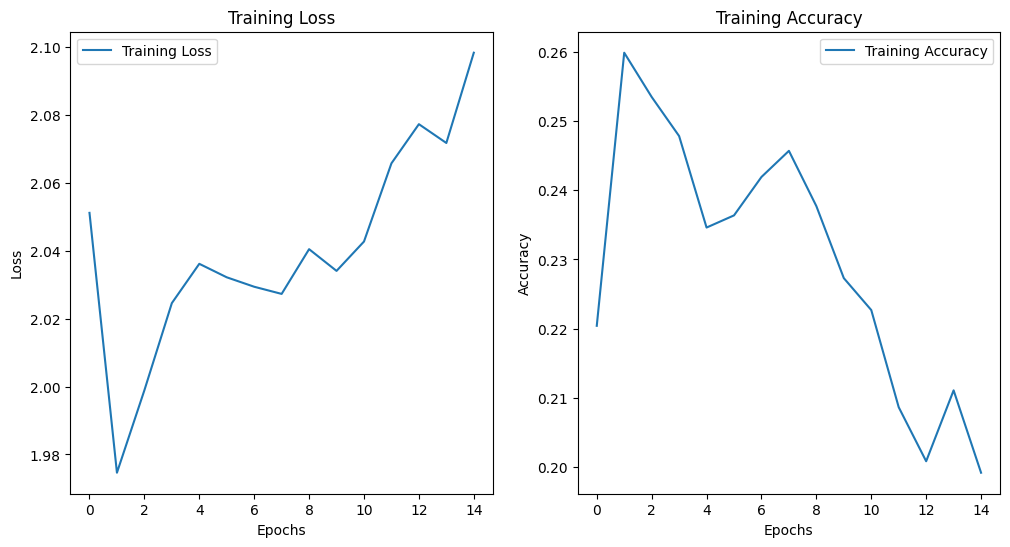

In [5]:
# Set 5:
set5_model = CNN(
    num_filters=[64, 64],
    kernel_size=[(3,3), (3,3)],
    strides=[(2,2), (2,2)],
    conv_activation='relu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_5",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)
set5_model.train(train_data, test_data, batch_size=64, shuffle_buffer_size=500, epochs=15, learning_rate=0.01, optimizer='rmsprop')
set5_model.visualize_last_performance()

Model: "Set_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        1792      
                                                                 
 batch_normalization_2 (Bat  (None, 15, 15, 64)        256       
 chNormalization)                                                
                                                                 
 average_pooling2d (Average  (None, 7, 7, 64)          0         
 Pooling2D)                                                      
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 batch_normalization_3 (Bat  (None, 3, 3, 128)         512   

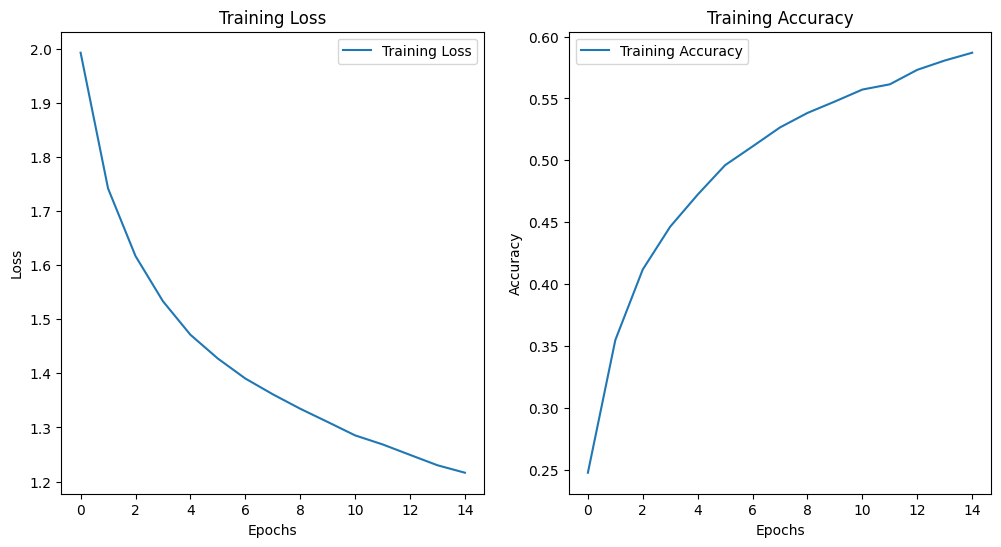

In [6]:
# Set 6:
set6_model = CNN(
    num_filters=[64, 128],
    kernel_size=[(3,3), (3,3)],
    strides=[(2,2), (2,2)],
    conv_activation='relu',
    cnn_pool_type='av_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='av_max',
    name="Set_6",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)
set6_model.train(train_data, test_data, batch_size=64, shuffle_buffer_size=500, epochs=15, learning_rate=0.01, optimizer='rmsprop')
set6_model.visualize_last_performance()

Model: "Set_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        1728      
                                                                 
 batch_normalization_4 (Bat  (None, 30, 30, 64)        256       
 chNormalization)                                                
                                                                 
 average_pooling2d_2 (Avera  (None, 15, 15, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 128)       73728     
                                                                 
 batch_normalization_5 (Bat  (None, 13, 13, 128)       512   

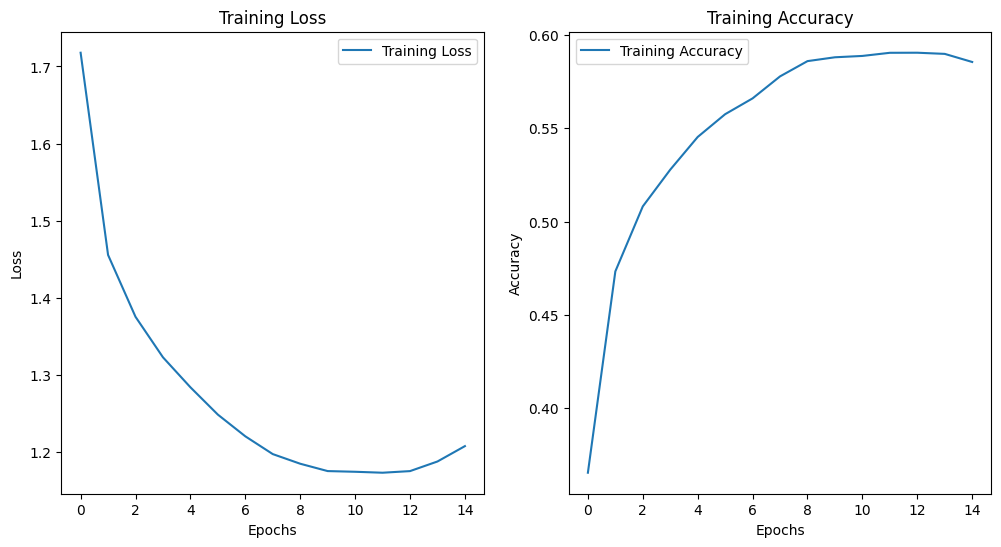

In [7]:
# Set 7:
set7_model = CNN(
    num_filters=[64, 128],
    kernel_size=[(3,3), (3,3)],
    strides=[(1,1), (1,1)],
    conv_activation='relu',
    cnn_pool_type='av_pool',
    padding='valid',
    use_bias=False,
    dense_activation='tanh',
    dense_sizes=[128],
    flatten_type='av_max',
    name="Set_7",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)
set7_model.train(train_data, test_data, batch_size=32, shuffle_buffer_size=1000, epochs=15, learning_rate=0.01, optimizer='rmsprop')
set7_model.visualize_last_performance()

Model: "Set_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 31, 31, 32)        384       
                                                                 
 batch_normalization_6 (Bat  (None, 31, 31, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        8192      
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 64)        256   

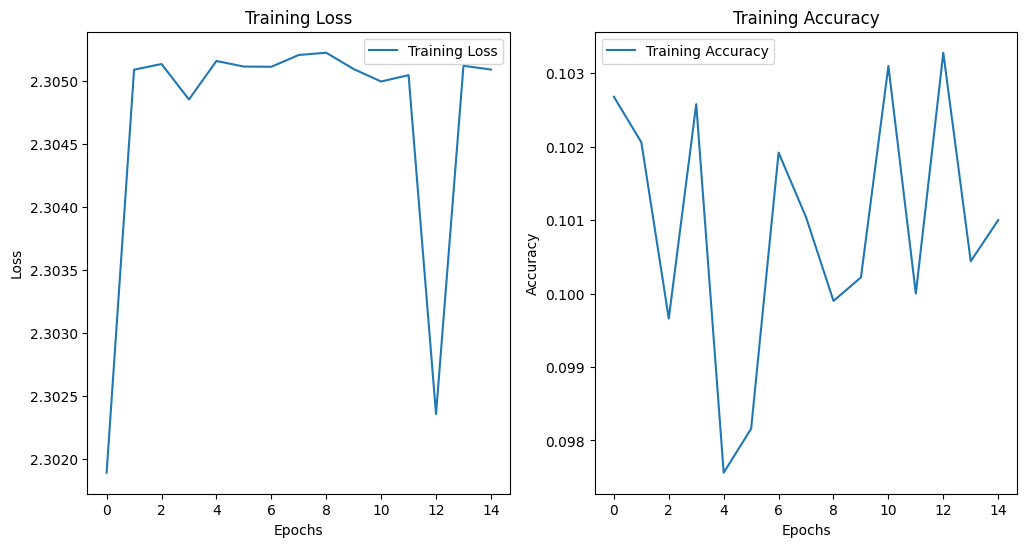

In [8]:
# Set 8:
set8_model = CNN(
    num_filters=[32, 64, 128, 128],
    kernel_size=[(2,2), (2,2), (2,2), (2,2)],
    strides=[(1,1), (1,1), (1,1), (1,1)],
    conv_activation='elu',
    cnn_pool_type= 'max_pool',
    padding='valid',
    use_bias=False,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_8",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)
set8_model.train(train_data, test_data, batch_size=32, shuffle_buffer_size=1000, epochs=15, learning_rate=0.01, optimizer='rmsprop')
set8_model.visualize_last_performance()